# Intro

This is a PyTorch Tutorial for the Deep Reinforcement Learning for Satellite Constellation Planning at AMLD 2024.

There's already a bunch of great tutorials that you might want to check out, and in particular [this tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
This tutorial covers a lot of the same material. If you're familiar with PyTorch basics, you might want to skip ahead to the PyTorch Advanced section.

First, let's import some things and define a useful plotting function.

In [ ]:
#@title imports and define `plot`
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import torch.nn.functional as F

def plot(xs, ys, xlim=(-3, 3), ylim=(-3, 3)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')

  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

If you have a GPU, check what device is being used by torch.

In [ ]:
torch.cuda.get_device_name(torch.cuda.current_device())

# Review: Numpy

Numpy arrays are objects that allow you to store and manipulate matrices.

In [ ]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([[8, 0, 7], [3, 0, 1]])
z = np.random.rand(3, 2, 3)
print(f"x, shape={x.shape}:\n{x}\n")
print(f"y, shape={y.shape}:\n{y}\n")
print(f"z, shape={z.shape}:\n{z}\n")

Numpy is much faster than pure Python:

In [ ]:
def benchmark_python_add(list_a: list, list_b: list):
    result = []
    for a, b in zip(list_a, list_b):
      result.append(a + b)

def benchmark_numpy_add(array_a: np.ndarray, array_b: np.ndarray):
    return array_a + array_b

arr_a = np.random.normal(size=(100000,))
list_a = list(arr_a)
arr_b = np.random.normal(size=(100000,))
list_b = list(arr_b)
print("Python:")
%timeit benchmark_python_add(list_a, list_b)
print("Numpy:")
%timeit benchmark_numpy_add(arr_a, arr_b)

You can index into Numpy arrays similar to Python lists (with integers or slices), with the addition of being able to specify indices for multiple dimensions.

In [ ]:
x = np.arange(1, 21, 1).reshape(4, 5)
print(x)
print()
print(x[2]) # Single index
print(x[2, 3]) # Indices for multiple dimensions
print(x[2:4, 3]) # Combining integer index and slice

## Numpy arithmetic and broadcasting

You can add/subtract/multiple/divide numpy arrays, as long as their dimensions match:

In [ ]:
a = np.ones((2, 3))
print(a)
print("+")
print(y)
print("=")
print(a + y)

You can also sometimes do arithmetic operations on arrays whose dimensions don't match exactly. Whenever possible, values will be "copied" so that the dimensions match:

In [ ]:
print(f"3\n*\n{a}\n=\n{3*a}\n")

a = np.array([1, 2, 3])
print(f"{a}\n+\n{z}\n=\n{a+z}")

This is called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), and it has many benefits:
- More concise code
- Duplicated values aren't explicitly created/stored in memory
- Repeated operations are optimized to run faster

## Axes

Numpy arrays have **axes**, which are like the "directions" along which you can do things. For example, in 2D:

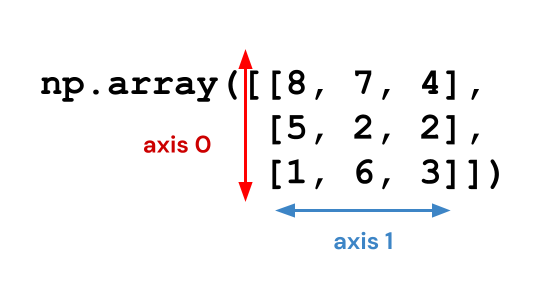

In [ ]:
x = np.array([[8, 7, 4], [5, 2, 2], [1, 6, 3]])
print(np.sum(x))
print(np.sum(x, axis=0))
print(np.sum(x, axis=1))
# print()
print(np.max(x))
print(np.max(x, axis=0))
print(np.max(x, axis=1))

More generally, you can think of an axis as the index of one of the values in the array's shape. If you do a reduction operation (e.g. sum, max) on a certain axis, that axis will disappear from the array's shape:

In [ ]:
z = np.random.randint(10, size=(3, 2, 4, 5))
print(np.sum(z, axis=2).shape)
print(np.sum(z, axis=(0, 2)).shape)

## Shapes and reshaping

Be careful about the shape of your numpy arrays, especially when you're working with vectors (where one of the dimensions is 1)!

In [ ]:
# These two are different things!
x = np.random.randint(10, size=(10,))
y = np.random.randint(10, size=(10, 1))
print(x)
print(y)

In [ ]:
# If you multiply a shape (n,) array with a (n,1) array, you actually get a shape (n,n) matrix:
print(x)
print("*")
print(y)
print("=")
print(x * y)

When writing numpy code, you should **always** keep track of the expected shape of each array and what each axis corresponds to. There are a few ways to do this:
 * Asserts (`assert x.shape == (batch_size, hidden_dim)`)
 * Comments (`# shape (B, C, W, H)`)
 * Fancier typechecking libraries (`jaxtyping`, `torchtyping`, etc.)

In [ ]:
z = x * y
assert z.shape == x.shape, f"Expected x*y to have shape {x.shape} but got {z.shape}"

In [ ]:
# If your intention is to multiply the two vectors element-wise, you need to reshape one of them first!
x_reshaped = x.reshape(-1, 1) # -1 means "infer this dimension"
print()
print(x_reshaped)
print("*")
print(y)
print("=")
print(x_reshaped * y)

It's pretty common to have to add/remove an axis from a numpy array, so there's some useful syntax to do this:

In [ ]:
# Removing axis/axes from an array
print(y.shape)
print(y.reshape(10).shape)
print(y.squeeze().shape)

In [ ]:
# Adding axis/axes to an array
print(x.shape)
# print(x.reshape(-1, 1).shape)
print(x[:, np.newaxis].shape)
print(x[:, None].shape) # Same as above, but not as readable

The benefits of `squeeze` and `np.newaxis` become clearer when you're working with more dimensions:

In [ ]:
a = np.random.randint(10, size=(10, 1, 4, 1, 1, 6, 2))
print(a.shape)
print(a.reshape(10, 4, 1, 6, 2).shape)
print(a.squeeze((1, 3)).shape)

In [ ]:
b = np.random.randint(10, size=(10, 4, 2, 7, 8, 9))
print(b.shape)
print(b.reshape(10, 1, 4, 1, 2, 7, 8, 9).shape)
print(b[:, np.newaxis, :, np.newaxis, ...].shape) # ... means "rest of dimensions"

## Array Multiplication

Numpy has two multiplication operators: `*` and `@`.
- `*` does **element-wise** multiplication.
- `@` does **matrix** multiplication.

In [ ]:
matrix = np.random.randint(10, size=(5, 5))
row_vec = np.random.randint(10, size=(5,))
col_vec = row_vec.reshape(5, 1)

# Outer product
print(col_vec)
print("*")
print(row_vec)
print("=")
print(col_vec * row_vec)

In [ ]:
# Dot product
print(row_vec)
print("@")
print(col_vec)
print("=")
# print((row_vec @ col_vec)) # Result will be a shape (1,) array
# print(row_vec.dot(col_vec).squeeze()) # Same as above
print(row_vec @ col_vec.squeeze()) # Works on arrays with same shape too (to get scalar)

Below are some other common Numpy operations you'll probably find useful at some point in this class:

In [ ]:
# transpose: reorders the axes of the array
z = np.random.rand(28, 28, 3)
z_transposed = z.transpose((2, 0, 1))
assert z_transposed.shape == (3, 28, 28)
print("Orig shape:", z.shape)
print("New shape: ", z_transposed.shape)


# PyTorch Basics

PyTorch is built around _tensors_, which are very similar to numpy arrays. You can do many of the same operations in PyTorch; everything we covered above applies to PyTorch tensors as well!

In [ ]:
x = torch.zeros(2, 3)
y = torch.ones(2, 3)
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

Reduction operations work the same way as they do in Numpy, except we use the argument `dim` instead of `axis`:

In [ ]:
print(torch.sum(z, dim=1))
print(torch.sum(z, dim=0))

Also like Numpy, PyTorch will try to broadcast operations:

In [ ]:
x = torch.ones((3, 1))
y = torch.ones((1, 3))
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

## Moving between numpy and PyTorch

In [ ]:
x_np = np.random.randn(2, 3)
print(x_np)

Use `torch.from_numpy` to convert from numpy array -> PyTorch tensor. The resulting tensor shares the same memory as the numpy array:

In [ ]:
x = torch.from_numpy(x_np)
print(x)

x_np[:] = 0
print(x)

By default, numpy arrays are float64. You'll probably want to convert arrays to float32, as most tensors in pytorch are float32.

In [ ]:
x = torch.from_numpy(x_np).float()
print(x)

Use `.numpy()` to convert from PyTorch tensor -> numpy array:

In [ ]:
print(x.numpy())

## Neural-Network specific functions
PyTorch has a bunch of built-in funcitons.
See [the docs](https://pytorch.org/docs/stable/torch.html) for a full list.

In [ ]:
# Activation functions
xs = torch.linspace(-3, 3, 100)
ys = torch.relu(xs)
plot(xs.numpy(), ys.numpy())
ys = torch.sigmoid(xs)
plot(xs.numpy(), ys.numpy())
ys = torch.tanh(xs)
plot(xs.numpy(), ys.numpy())

In [ ]:
x = torch.tensor([[2, 3.5],
                  [4, 4]])
torch.softmax(x, dim=-1) # for predicting probabilities, do softmax along last dimension (by row)

## Automatic differentiation

Given some loss function
$$L(\vec x, \vec y) = ||2 \vec x + \vec y||_2^2$$
we want to evaluate
$$\frac{\partial L}{\partial \vec x}$$
and
$$\frac{\partial L}{\partial \vec y}$$

In [ ]:
# By default, tensors have requires_grad=False. Need to specify if you want
# the gradients for a tensor!
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)

PyTorch makes this easy by having tensors keep track of their data...

In [ ]:
x.data

...and their gradient:

In [ ]:
print(x.grad)

However, right now `x` has no gradient because it does not know what loss it must be differentiated with respect to.
Below, we define the loss.

In [ ]:
loss = ((2 * x + y)**2).sum()
print(loss)

Notice the `grad_fn` property on the tensor. We can trace our way back through these grad functions to see the whole computation graph:

In [ ]:
grad_fns = [(loss.grad_fn, 0)]
curr_level = 0
lines = []
while grad_fns:
    prev_level = curr_level
    fn, curr_level = grad_fns.pop()
    if curr_level != prev_level:
        print("---")
    print(fn.name())
    for next_fn, _ in fn.next_functions:
        if next_fn:
            grad_fns.append((next_fn, curr_level + 1))

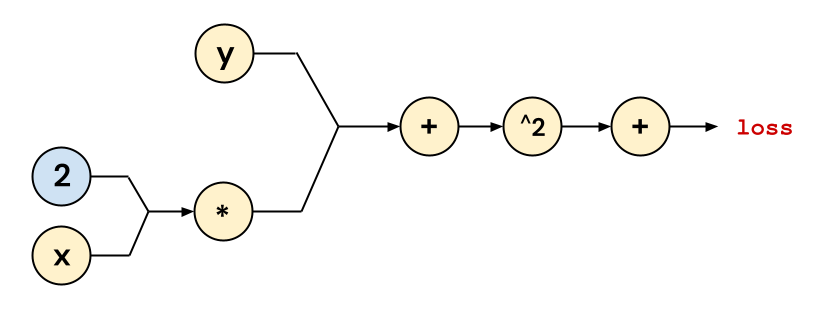

Each of the yellow nodes above has a `.grad` property which will store the gradients accumulated during backprop.

To perform backprop, call `.backward()` on the loss:

In [ ]:
loss.backward()

Now we see that the gradients are populated!

In [ ]:
print(x.grad)
print(y.grad)

### gradients accumulate
Gradients accumulate, so if you call backwards twice...

In [ ]:
loss = ((2 * x + y)**2).sum()
loss.backward()

...you'll get twice the gradient.

In [ ]:
print(x.grad)
print(y.grad)

### multiple losses

This accumulation makes it easy to add gradients from different losses, which might not even use the same parameters. For example, this loss is only a function of `x`....

In [ ]:
other_loss = (x**2).sum()
other_loss.backward()

...and so only `x.grad` changes.

In [ ]:
print(x.grad)
print(y.grad)

### stopping and starting gradients

If you don't specify `required_grad=True`, the gradient will always be `None`.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

You can turn `required_grad` back on after initializing a tensor.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
y.requires_grad = True
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

You can cut a gradient by calling `y.detach()`, which will return a new tensor with `required_grad=False`. Note that `detach` is not an in-place operation! You would want this during evaluation.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)
y_detached = y.detach()
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)
print(y_detached.grad)
print(y.detach())

A few things to watch out for:
- You can't do any in-place operations on a tensor that has `requires_grad=True`. (This prevents you from inadvertently mutating it in a way that isn't tracked for backprop purposes.)

- You also can't convert a tensor with `requires_grad=True` to numpy (for the same reason as above). Instead, you need to detach it first, e.g. `y.detach().numpy()`.

- Even though `y.detach()` returns a new tensor, that tensor occupies the same memory as `y`. Unfortunately, PyTorch lets you make changes to `y.detach()` or `y.detach.numpy()` which will affect `y` as well! If you want to safely mutate the detached version, you should use `y.detach().clone()` instead, which will create a tensor in new memory.

RL Connection: You would want to be doing simulator-related tasks with numpy, convert to torch when doing model-related tasks, and convert back to feed output into simulator.

## Example: Regression Task
Let's train a simple neural network to model a sine wave. This is our target:

In [ ]:
x = torch.linspace(-5, 5, 100).view(100, 1)
print(x.shape)
y_target = torch.sin(x)
loss_fn = nn.MSELoss()
plot(x, y_target)

### Modules
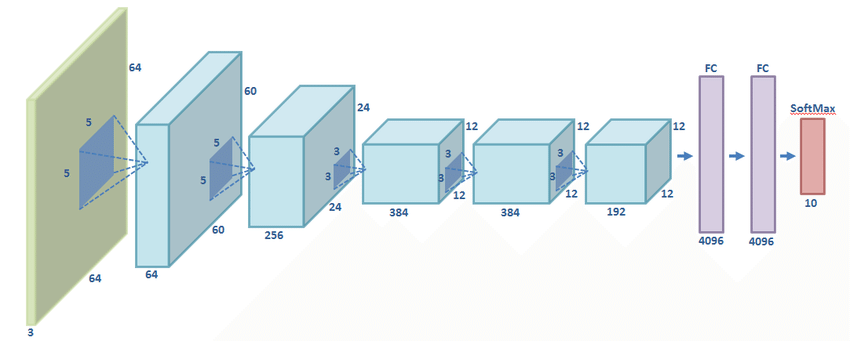

`nn.Module` represents the building blocks of a computation graph.
For example, in typical pytorch code, each convolution block above is its own module, each fully connected block is a module, and the whole network itself is also a module.
Modules can contain modules within them.
All the classes inside of `torch.nn` are instances `nn.Modules`.
Below is an example definition of a module:

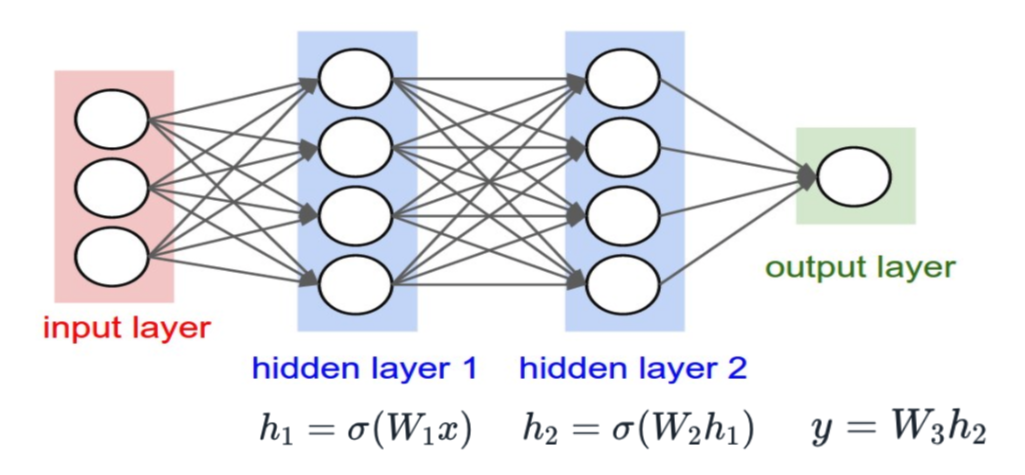

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The main function that you need to implement is the `forward` function.
Otherwise, it's a normal Python object:

In [ ]:
net = Net(input_size=1, output_size=1)
print(net)

To evaluate a neural network on some input, you pass an input through a module by calling it directly. In particular, don't call `net.forward(x)`.

In [ ]:
y = net(x)
# net.forward(x) <- DON'T DO THIS
print(y.shape)

Let's visualize what the network looks like before training.

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

Let's look into what the `nn.Module` is doing...

In the `__init__` function, any variable that you assign to `self` that is also a module will be automatically added as a sub-module. The parameters of a module (and all sub-modules) can be accessed through the `parameters()` or `named_parameters()` functions:

In [ ]:
for name, p in net.named_parameters():
  print(name, p.shape)

These parameters will automatically have their gradients stored (i.e. `requires_grad=True`)

In [ ]:
print(net.fc1.bias.grad)

WARNING: if you want to have a list of modules use
```
def __init__(self, network1, network2):
  self.list = nn.ModuleList([network1, network 2])
```
and **not**
```
def __init__(self, network1, network2):
  self.list = [network1, network 2]
```
In the latter case, `network1` and `network2` won't be added as sub-modules and their gradients won't be tracked.

The output of the module is just a tensor. We can perform operations on the tensor like before to automatically compute derivatives.
For example, below, we minimize the sum-of-squared-errors.

In [ ]:
loss = ((y - y_target)**2).sum()
loss.backward()

We can manually update the parameters by adding the gradient (times a negative learning rate) and zero'ing out the gradients to prevent gradient accumulation.

In [ ]:
for p in net.parameters():
  p.data.add_(-0.001 * p.grad)
  p.grad.data.zero_()

And we can do this in a loop to train our network!

In [ ]:
for _ in range(100):
  y = net(x)
  loss = ((y - y_target)**2).sum()
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

Sure enough, our network learns something close to a sine wave.

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

PyTorch has functions that can do a lot of these functions (i.e. loss) for you!

### Loss Functions
PyTorch has a bunch of built in loss functions, which are just other modules that you can pass your data through.

In [ ]:
loss_fn = nn.MSELoss()
loss_fn(torch.tensor([1.4, 3.3, 1.9]), torch.tensor([1, 3, 2]))

In [ ]:
net = Net(input_size=1, output_size=1)

for _ in range(1000):
  y = net(x)
  loss = loss_fn(y, y_target)
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

### Optimizers

We can also use the `optim` package for built-in optimizers instead of implementing gradient descent ourselves.

In [ ]:
from torch import optim

net = Net(input_size=1, output_size=1)

optimizer = optim.Adam(net.parameters(), lr=1e-3) # or SGD, RMSProp

x = torch.linspace(-5, 5, 100).view(-1, 1)
y = net(x)
y_target = torch.sin(x)
loss_fn = nn.MSELoss()

Here's the network before training

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

and here's how you can use the optimize to train the network.
Note that we call `zero_grad` _before_ calling `loss.backward()`, and then we just call `optimizer.step()`. This `step` function will take care of updating all the parameters that were passed to that optimizer's constructor.

In [ ]:
for _ in range(100):
  y = net(x)
  loss = loss_fn(y, y_target)

  optimizer.zero_grad() # zero's out gradients
  loss.backward() # populate gradients
  optimizer.step() # update each parameter via gradient descent

And we see that this trained a network quite well:

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

To summarize, here's what we did:

- Defined a class for our neural network (subclass of `nn.Module`)
- Specified a loss function (MSE loss) and optimizer (Adam) --> make sure to pass all model parameters (especially for multimodal)
- Performed training by doing the following in a loop:
    - Make prediction
    - Compute loss
    - Zero the stored gradients
    - Backprop the loss with `.backward()`
    - Update the weights by taking a step of gradient descent

## GPU support

Most of the time, you'll want to do your training on a GPU so that it runs much faster.

PyTorch makes it easy to move tensors between CPU <-> GPU for training...

In [ ]:
# Checking whether GPU is available
print(torch.cuda.is_available())

# Initialize a tensor on GPU instead of CPU
device = torch.device("cuda")
y = torch.ones((2, 3), device=device)
print(y)

In [ ]:
device = torch.device("cuda")
x = torch.zeros((2, 3))
y = torch.ones((2, 3), device=device)
z = x + y

You can move a tensor to the GPU by using the `to` function.

In [ ]:
x = x.to(device)
z = x + y
print(z)

You can't convert tensors on a GPU into numpy arrays directly. This will error:

In [ ]:
z.numpy()

Instead, you will need to first move the tensor to CPU before converting to numpy.

In [ ]:
z_cpu = z.to('cpu')
z_cpu.numpy()

Let's look at the speed of torch (on GPU) compared to numpy and pure Python using our benchmark from earlier:

In [ ]:
def benchmark_torch_add(tensor_a: torch.Tensor, tensor_b: torch.Tensor):
    return tensor_a + tensor_b

tensor_a = torch.from_numpy(arr_a).cuda()
tensor_b = torch.from_numpy(arr_b).cuda()
print("Python:")
%timeit benchmark_python_add(list_a, list_b)
print("Numpy:")
%timeit benchmark_numpy_add(arr_a, arr_b)
print("Torch CUDA:")
%timeit benchmark_torch_add(tensor_a, tensor_b)

In [ ]:
# Will not work in this notebook, but you can do this on the homework assignments!
from amld.infrastructure import pytorch_util as ptu
ptu.from_numpy(x_np)
ptu.to_numpy(x)

## Full training example

Now let's do the same training example end-to-end, with GPU support added in:

### Training the model

In [ ]:
# Define the data
x = torch.linspace(-5, 5, 100).view(-1, 1)
y_target = torch.sin(x)

net = Net(input_size=1, output_size=1)
########## (NEW) ##########
# Set up GPU device (if available) and move model and targets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net = net.to(device)
y_target = y_target.to(device)
########## (NEW) ##########

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
losses = []

for _ in range(300):
    ########## (NEW) ##########
    x = x.to(device)
    # y_target = y_target.to(device)
    ########## (NEW) ##########
    y = net(x)
    loss = loss_fn(y, y_target)
    losses.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot(range(300), losses, xlim=(0, 300))

### Evaluating the model

Notice the `.eval()` and `with torch.no_grad()` -- make sure to include these whenever making predictions at test time!

In [ ]:
net.eval() # Switches the network to evaluation mode, disabling things like dropout and batch norm
with torch.no_grad(): # Temporarily disables all `requires_grad` within the enclosed block
    y = net(x)
plot(x.cpu().numpy(), y.cpu().numpy())

### Saving (and loading) model weights

Once you're done training, you'll probably want to save the weights of your model for later use.

In [ ]:
# Save a dictionary of parameter names and their values
PATH = "checkpoint.pt"
torch.save(net.state_dict(), PATH)
# saves everything including parameters and other state values (i.e. batch norm mean)

In [ ]:
# Later: Initialize a new model and load the saved state dict
new_model = Net(input_size=1, output_size=1) # with same architecture
new_model.to(device)
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

for (name1, val1), (name2, val2) in zip(net.state_dict().items(), new_model.state_dict().items()):
    assert name1 == name2 and torch.equal(val1, val2), f"{name1} and {name2} states differ!"

# PyTorch - Advanced

## Distributions
PyTorch has a very convenient [distributions](https://pytorch.org/docs/stable/distributions.html) package for probability distributions. This is useful since in RL we often work with stochastic policies (e.g. $\pi(a|s_0)= $ some Gaussian distribution).

In [ ]:
from torch import distributions

You create distributions by passing the parameters of the distribution.

In [ ]:
# Univariate Gaussian with mean 0, std 1
mean = torch.zeros(1, requires_grad=True)
std = torch.ones(1, requires_grad=True)
gaussian = distributions.Normal(mean, std)

These distributions are instances of the more general `Distribution` class, which you can read more about [here](https://pytorch.org/docs/stable/distributions.html#distribution).

The two most useful operations you can do with `Distribution` objects are `sample` and `log_prob`:

In [ ]:
sample = gaussian.sample((1,))
print(sample)

In [ ]:
log_prob = gaussian.log_prob(sample)

The log probability depends on the the parameters of the distribution. So, calling `backward` on a loss that depends on `log_prob` will back-propagate gradients into the parameters of the distribution.

NOTE: this won't back-propagate through the samples (the "reparameterization trick''), unless you use `rsample`, which is only implemented for some distributions.

In [ ]:
loss = -log_prob.sum()

In [ ]:
loss.backward()

In [ ]:
print(mean.grad)

### Batch-Wise distribution

The distributions also support batch-operations. In this case, all the operations (`sample`, `log_prob`, etc.) are batch-wise.

In [ ]:
mean = torch.zeros(10)
std = torch.ones(10)
gaussian = distributions.Normal(mean, std)

In [ ]:
print(gaussian)
print(gaussian.batch_shape)

In [ ]:
sample = gaussian.sample((3,))
print(sample)

In [ ]:
gaussian.log_prob(sample)

### Multivariate Normal

You can also define a multivariate normal distribution, which allows you to use nondiagonal covariance matrices.

In [ ]:
mean = torch.zeros(2)
covariance = torch.tensor(
    [[1, 0.8],
     [0.8, 1]]
)
gaussian = distributions.MultivariateNormal(mean, covariance) # can model dependencies between different components

In [ ]:
gaussian.sample((1,))

In [ ]:
samples = gaussian.sample((500,))
plt.gca().set_aspect("equal")
plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy())

### Understanding distribution shapes

There are three different "shapes" that you need to keep in mind when defining and sampling from a distribution:

In [ ]:
mean = torch.zeros(2)
covariance = torch.tensor(
    [
     [[1, 0.8],
     [0.8, 2]],
     [[1, -0.2],
      [-0.2, 1]],
     [[4, 0.6],
      [0.6, 0.5]]
    ]
)
gaussian = distributions.MultivariateNormal(mean, covariance)
sample = gaussian.sample((5,))

print(gaussian.batch_shape)
print(gaussian.event_shape)
print(sample.shape)

- **Batch shape**: The number of different (possibly non-iid) values you will sample at once.
    - Specified when initializing the distribution. In the example above, it's the number of covariance matrices we provide (3)
- **Event shape**: The shape of a single sample from one of the distributions in the batch.
    - Specified when initializing the distribution. In the example above, it's the size of our covariance matrix (2)
- **Sample shape:** The number of iid samples we take from the overall distribution.
    - Specified when calling `sample()`. In the example above, we asked for a sample shape of `(5,)`

In general, when you call `dist.sample(sample_shape)`, the result will have shape `(sample_shape, batch_shape, event_shape)`.

### Categorical Distribution

Another useful distribution is the categorical distribution.

In [ ]:
probs = torch.tensor([0.1, 0.2, 0.7])
dist = distributions.Categorical(probs=probs)

In [ ]:
sample = dist.sample([20])
print(sample)

In [ ]:
dist.log_prob(sample)

### Distributions in neural nets

Typically, your network will output the parameters of a distribution (e.g. the mean and covariance of a Gaussian):

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
mean_network = Net(1, 1)
x = torch.randn(100, 1)
mean = mean_network(x)
distribution = distributions.Normal(mean, scale=1)
distribution

If you want, your nn.Module can return a distribution in the `forward` function instead!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return distributions.Normal(x, scale=1)

In [ ]:
distribution_network = Net(1, 1)
x = torch.randn(100, 1)
distribution = distribution_network(x)
distribution

### Example: Training a conditional Gaussian model

Let's use what we've covered to train a Gaussian model:

$$\pi(a|s) \sim \mathcal{N} (f_\theta(s), \Sigma)$$

(To make this example concrete, you could imagine that we're trying to learn a policy through behavior cloning given some data from an expert. Given some state $s$, our policy will output a Gaussian action distribution $\pi(a|s)$, whose mean and standard deviation we will predict using a neural network.)

In [ ]:
class GaussianPolicy(nn.Module):
    def __init__(self, input_size, output_size):
        super(GaussianPolicy, self).__init__()

        # Mean will be a function of input; std will be a fixed (learned) value
        self.mean_fc1 = nn.Linear(input_size, 32)
        self.mean_fc2 = nn.Linear(32, 32)
        self.mean_fc3 = nn.Linear(32, output_size)
        self.log_std = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        mean = F.relu(self.mean_fc1(x))
        mean = F.relu(self.mean_fc2(mean))
        mean = self.mean_fc3(mean)
        return distributions.Normal(mean, self.log_std.exp())

As you can see, the forward pass outputs a multivariate normal distribution for the _output size_ actions possible. Each actions gets its normal distribution. We can then sample this normal distribution to get actions probability given input state. We can then choose the most probable action. 

In [ ]:
states = torch.rand(1000, 2) - 0.5 # 1000 samples of 2-dimensional states

true_means = states**3 + 4.5*states
true_cov = torch.diag(torch.tensor([0.1, 0.05]))
expert_actions = torch.distributions.MultivariateNormal(true_means, true_cov).sample()

plt.scatter(expert_actions[:,0], expert_actions[:,1])

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

policy = GaussianPolicy(2, 2)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

dataset = TensorDataset(states, expert_actions)
loader = DataLoader(dataset, batch_size=64, shuffle=True) # gives you data in batches

losses = []
for epoch in range(200):
    epoch_loss = 0
    for curr_states, curr_actions in loader:
        dist = policy(curr_states)
        # dist = torch.distributions.Normal(mean, torch.exp(log_std))
        loss = -dist.log_prob(curr_actions).sum()

        optimizer.zero_grad()
        loss.backward()
        epoch_loss += loss.detach().cpu().numpy().squeeze()
        optimizer.step()
    losses.append(epoch_loss / len(loader))

plt.plot(losses)

In [ ]:
policy.eval()
with torch.no_grad():
    dist = policy(states)
    pred_means = dist.mean.cpu().numpy()
    pred_actions = dist.sample().cpu().numpy()

plt.figure()
plt.title("Sampled actions")
plt.scatter(pred_actions[:,0], pred_actions[:,1], color='r', label='learned policy')
plt.scatter(expert_actions[:,0], expert_actions[:,1], color='b', label='expert')
plt.legend()

plt.figure()
plt.title("Action means")
plt.scatter(pred_means[:,0], pred_means[:,1], color='r', label='learned policy')
plt.scatter(true_means[:,0], true_means[:,1], color='b', label='expert')
plt.legend()

Takeaways:
- You can think distributions as anything else you can backprop through; you can easily learn any parameters of any distribution!
- Check out other pytorch tutorials for more specific information.

# Useful Functions


In [ ]:
x = torch.arange(6).reshape(2, 3)
y = torch.tensor([0, 1]).reshape(2, 1)
print(x)
print(y)
print(torch.gather(x, 0, y))

In [ ]:
x = torch.arange(6).reshape(2, 3)
y = torch.tensor([0, 1, 0]).reshape(1, 3)
print(x)
print(y)
print(torch.gather(x, 0, y))

For a 3-D tensor the output is specified by::

    out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
    out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
    out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2